In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from thalamus_merfish_analysis import ccf_plots as cplots
from thalamus_merfish_analysis import ccf_images as cimg
from thalamus_merfish_analysis import abc_load as abc
import thalamus_merfish_analysis.distance_metrics as dm
import spagcn_plots as spgplots
get_ipython().run_line_magic('matplotlib', 'inline') 

# Load ABC data + SpaGCN domains predictions

In [3]:
# load all cells in the brain 
# (realigned=True would load faster version)
realigned=False
obs = abc.get_combined_metadata(realigned=realigned, version="20230830", 
                                drop_unused=False, flip_y=False, round_z=True)
obs.index

Index(['1019171907102340387-1', '1104095349101460194-1', '1017092617101450577',
       '1018093344101130233', '1019171912201610094', '1017092617101300312',
       '1019171912101770241', '1019171910101420741', '1019171910101280057',
       '1104095349101450348',
       ...
       '1018093344201710102-1', '1104095349101170276-1', '1018135614101750622',
       '1019171910102600563', '1015221632100560519', '1018093344100380167-3',
       '1017165415100930567', '1017155956102610748', '1017155956101980080-1',
       '1018093344102220578-3'],
      dtype='string', name='cell_label', length=3739961)

In [4]:
# load in SpaGCN domain results
# temporarily a static file in '../code/resources' until I get a reproducible run setup for the spagcn capsule
spagcn_domains_df = pd.read_parquet('/code/resources/spagcn_predicated_domains.parquet')

# need to convert to categories since they're imported as int64
spagcn_domains_df = spagcn_domains_df.astype('category')
spagcn_domains_df

,res1pt4,res1pt0,res0pt7
cell_label,,,
1018093344101120291-2,22,18,10
1018093344101120325-1,22,18,10
1018093344101110066-3,14,18,17
1018093344100960681-1,14,18,9
1018093344101110238-1,14,18,9
...,...,...,...
1018093345101610118-1,17,14,15
1018093345101620074,17,14,15
1018093345101450752-1,17,14,15


In [5]:
# merge in & subset to just cells with SpaGCN domain predictions
obs_spagcn = pd.merge(obs, spagcn_domains_df, on='cell_label', how='inner')
obs_spagcn.columns

Index(['brain_section_label', 'cluster_alias', 'average_correlation_score',
       'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex',
       'x_section', 'y_section', 'z_section', 'neurotransmitter', 'class',
       'subclass', 'supertype', 'cluster', 'neurotransmitter_color',
       'class_color', 'subclass_color', 'supertype_color', 'cluster_color',
       'x_reconstructed', 'y_reconstructed', 'z_reconstructed',
       'parcellation_index', 'x_ccf', 'y_ccf', 'z_ccf', 'parcellation_organ',
       'parcellation_category', 'parcellation_division',
       'parcellation_structure', 'parcellation_substructure',
       'parcellation_organ_color', 'parcellation_category_color',
       'parcellation_division_color', 'parcellation_structure_color',
       'parcellation_substructure_color', 'left_hemisphere', 'res1pt4',
       'res1pt0', 'res0pt7'],
      dtype='object')

## Set up other parameters

In [6]:
section_col = 'z_reconstructed'
sections_all = sorted(obs_spagcn[section_col].unique())
print(f'{sections_all}')

# 3 example sections for the GRC poster
sections_GRC = [6.4, 7.2, 8.0]

[5.0, 5.4, 5.6, 5.8, 6.2, 6.4, 6.6, 6.8, 7.0, 7.2, 7.6, 7.8, 8.0, 8.2]


In [7]:
if realigned:
    ccf_label = 'parcellation_structure_realigned'
    coords = 'section'
else:
    ccf_label = 'parcellation_structure'
    coords = 'reconstructed'

## Load CCF structures

In [8]:
ccf_images = abc.get_ccf_labels_image(resampled=True, realigned=realigned, 
                                        subset_to_left_hemi=True)
ccf_boundaries = cimg.sectionwise_label_erosion(ccf_images, distance_px=1, 
                                                fill_val=0, return_edges=True)

# Plots

## plot all sections to double check data import

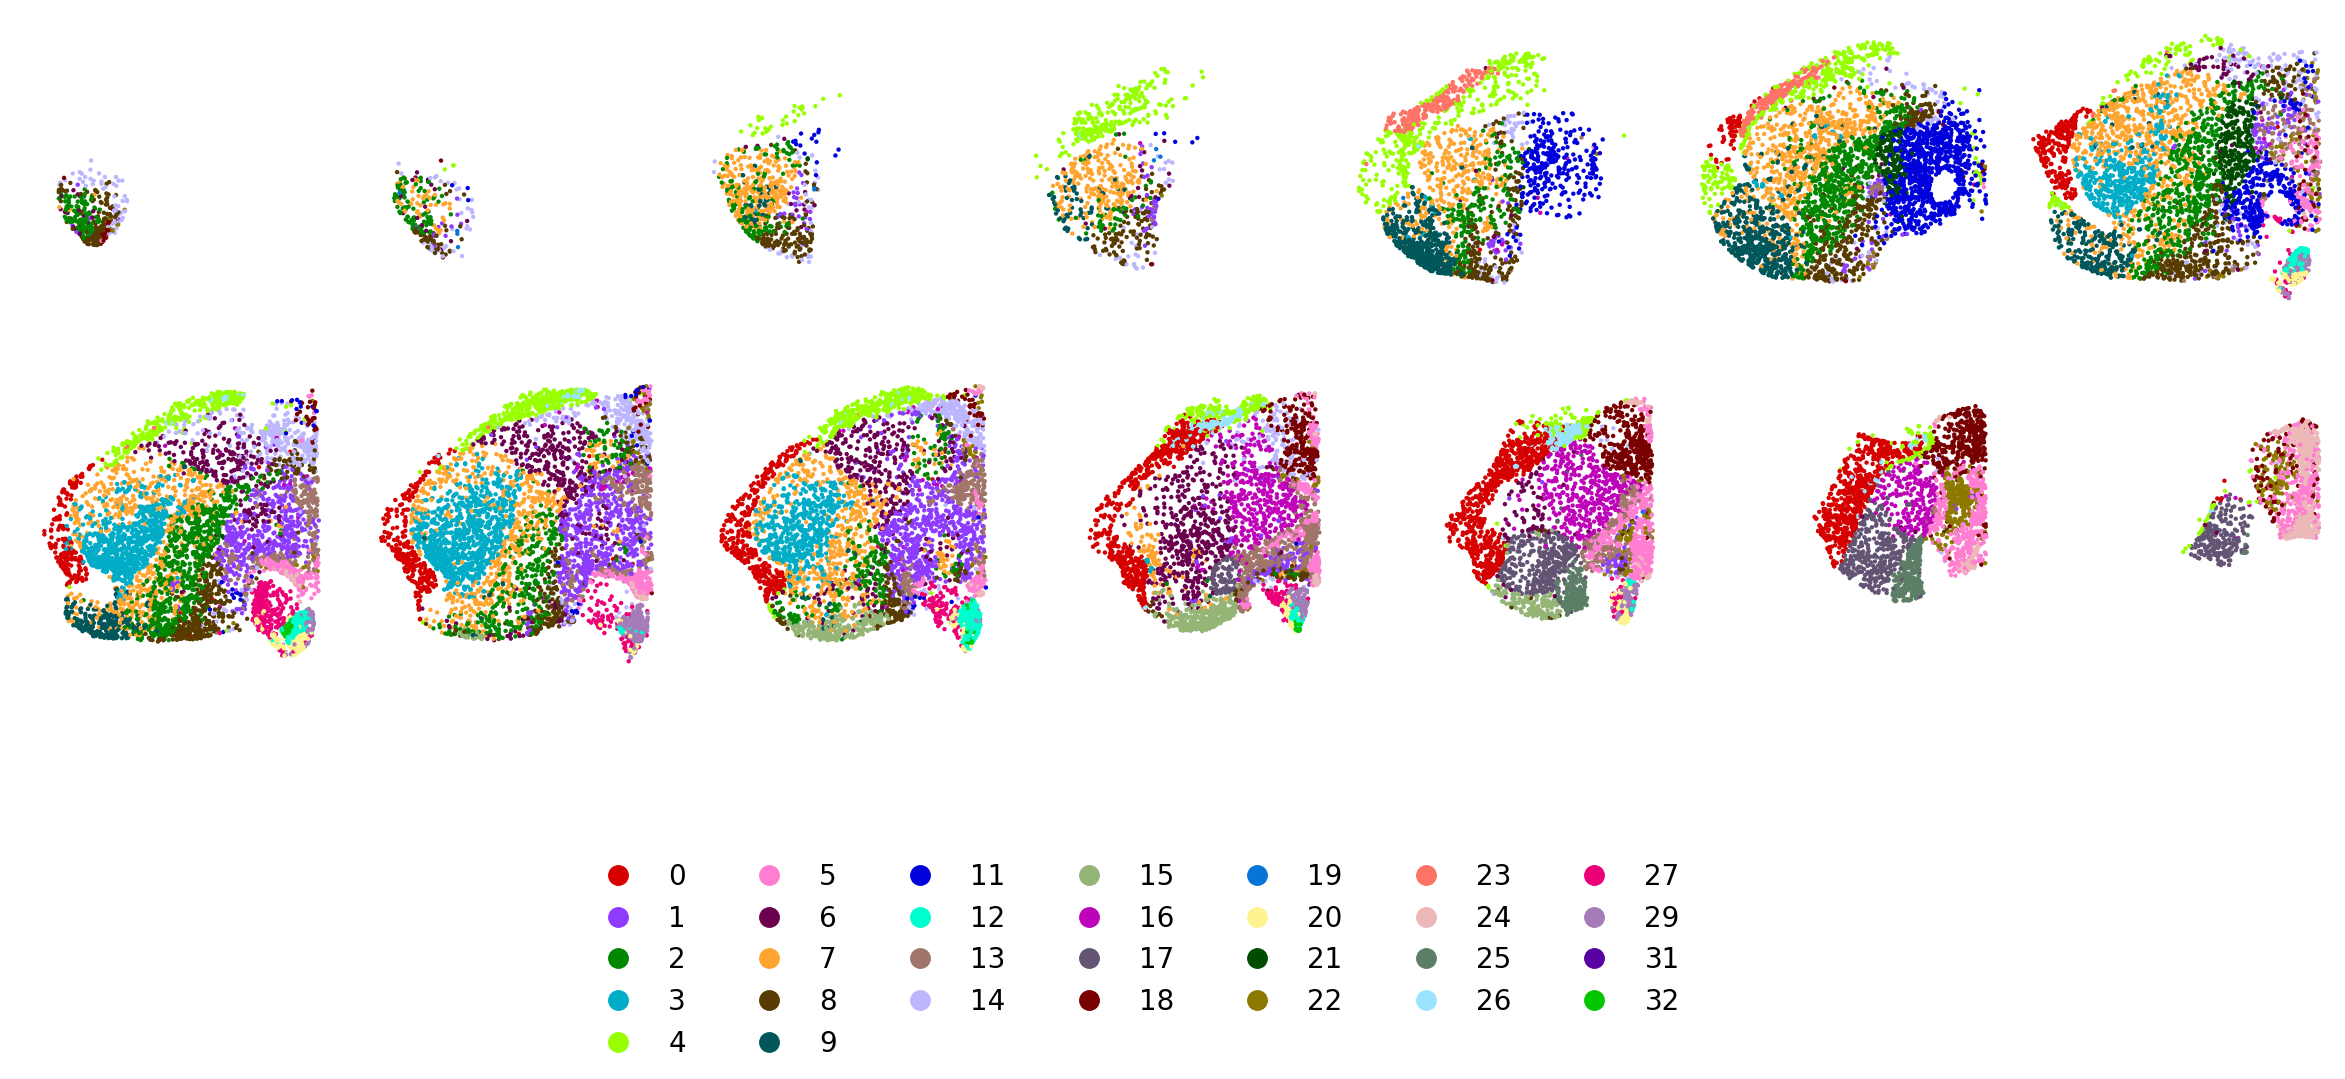

In [9]:
resolution = 1.4
res_str = str(resolution)
predicted_col = f'res{res_str[0]}pt{res_str[-1]}'
predicted_refined_col = f'res{res_str[0]}pt{res_str[-1]}_refined'

fig_all_sec = spgplots.plot_domains_multisection(obs_spagcn, predicted_col, 
                                                 obsm_key=None, 
                                                 sections=sections_all,
                                                 n_rows=2,
                                                 plot_title=None)

fig_all_sec.savefig(f'/results/spaGCN_multisec_res{resolution}.pdf', 
                    transparent=True, bbox_inches='tight')

## def plot_domains_overlay()

In [10]:
import pathlib
import numpy as np
import matplotlib.colors as clr
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.lines import Line2D
import seaborn as sns
from colorcet import glasbey

def plot_domains_overlay(data, pred_col, ccf_images, ccf_boundaries,
                         obsm_key='spaGCN_predicted_domains',
                         section_col='', 
                         x_col = 'x_'+coords, y_col = 'y_'+coords,
                         sections=None, n_rows=2, s=10, plot_title=None):
    
    # allow to input adata or just obs
    if hasattr(data, 'obs'):
        obs = ad.obs
        ad = data.copy()
    else:
        obs = data.copy()
    
    # set default plot title
    if plot_title==None:
        plot_title = 'SpaGCN MERFISH domains\n'+pred_col
        
    fig = plt.figure(figsize=(30, 10))
    # set grid geometry based on the number of sections
    if sections==None:
        section_ids = obs['brain_section_label'].cat.categories.tolist()
    else:
        section_ids = sections
    n_rows = n_rows
    n_cols = int(np.ceil(len(section_ids)/n_rows))

    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(n_rows, n_cols),  # creates 2x2 grid of axes
                     axes_pad=(0.1,0.6),  # pad between axes in inch.
                     # share_all=True
                     )
    
    # set domain:color mapping dict
    if obsm_key==None:
        hue_col = pred_col
    else:
        hue_col = 'spaGCN_domain'
        obs[hue_col] = ad.obsm[obsm_key][pred_col]
        
    spg_domain_ids = sorted(obs[hue_col].unique().tolist())
    print(f'{spg_domain_ids=}')
    sns_palette = sns.color_palette(glasbey, n_colors=len(spg_domain_ids))
    palette_dict = dict(zip(spg_domain_ids, sns_palette))
        
    # plot each domain separately
    for i, sec in enumerate(section_ids):
        ax = grid[i]
        obs_sec = obs[obs['z_reconstructed']==sec]
        
        sns.scatterplot(obs_sec, ax=ax, x='x_reconstructed', y='y_reconstructed', 
                        hue=hue_col, s=s, palette=palette_dict, 
                        linewidth=0, legend=False)
        ax.set_aspect('equal', 'box')
        # hide all x-y axes, ticks, labels, etc.
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.spines[['top', 'bottom', 'right', 'left']].set_visible(False)
        
    # # custom legend that's shared across & inclusive of all plotted sections    
    # legend_handles = [Line2D([0], [0], linestyle='None', marker='o', 
    #                          markersize=14, color=color, label=label) 
    #                   for label, color in palette_dict.items()]
    # legend = fig.legend(handles=legend_handles, loc='upper center', 
    #                     bbox_to_anchor=(0.5, 0), ncol=n_cols, frameon=False, 
    #                     fontsize=20)
    plt.show()
    return fig

In [11]:
def plot_ccf_overlay_montage(obs, ccf_images, sections=None, ccf_names=None, 
                             point_hue='CCF_acronym', legend='cells', 
                             min_group_count=10, min_section_count=20, 
                             highlight=[], face_palette=None, edge_color='grey',
                             point_palette=None, bg_cells=None, s=2,
                             show_axes=False, section_col='section', x_col='cirro_x', 
                             y_col='cirro_y', categorical=True,
                             boundary_img=None, set_lims='whole', custom_xy_lims=[], 
                             n_rows=2):
    obs = obs.copy()
    # Set variables not specified by user
    if sections is None:
        sections = sorted(obs[section_col].unique())
    if ccf_names is None:
        ccf_names = cplots.get_thalamus_substructure_names()
    
    if isinstance(sections[0], str):
        raise Exception('str type detected for ''sections''. You must use ''z_section'' OR ''z_reconstructed'' as your ''section_col'' in order to plot the rasterized CCF volumes.')
        
    # Clean up point hue column    
    # string type (not categorical) allows adding 'other' to data slice by slice
    if categorical:
        obs[point_hue] = obs[point_hue].astype(str)
        # drop groups below min_group_count and sort by size
        # currently across all of obs, not just selected sections
        point_group_names = obs[point_hue].value_counts().loc[lambda x: x>min_group_count].index
        obs = obs[obs[point_hue].isin(point_group_names)]
        
        # Set color palette for cell scatter points
        if point_palette is None:
            point_palette = cplots._generate_palette(point_group_names)
        else:
            point_palette = point_palette.copy()
        point_palette.update(other='grey')
    
    if bg_cells is not None:
        bg_cells = bg_cells.loc[bg_cells.index.difference(obs.index)]
    
    # Display each section as a subplot in an ImageGrid
    # figs = []
    fig = plt.figure(figsize=(30, 10))
    # set grid geometry based on the number of sections
    n_rows = n_rows
    n_cols = int(np.ceil(len(sections)/n_rows))

    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(n_rows, n_cols),  # creates 2x2 grid of axes
                     axes_pad=(0.1,0.6),  # pad between axes in inch.
                     # share_all=True
                     )
    for i, section in enumerate(sections):
        secdata = obs.loc[lambda df: (df[section_col]==section)].copy()
        if len(secdata) < min_section_count:
            continue
        # fig, ax = plt.subplots(figsize=(8,4))
        ax = grid[i]
        ax.set_title('z='+str(section)+'\n'+point_hue)
        
        # display CCF shapes
        cplots.plot_ccf_section(ccf_images, section, boundary_img=boundary_img,
                                ccf_names=ccf_names, face_palette=shape_palette, 
                                legend=(legend=='ccf'), ax=ax)

        # display background cells in grey
        if bg_cells is not None:
            bg_s = s*0.8 if (s<=2) else 2
            if custom_xy_lims!=[]:
                bg_cells = cplots._filter_by_xy_lims(bg_cells, x_col, y_col, custom_xy_lims)
            sns.scatterplot(bg_cells.loc[lambda df: (df[section_col]==section)], 
                            x=x_col, y=y_col, c='grey', s=bg_s, alpha=0.5, 
                            linewidth=0, ax=ax)
        # lump small groups if legend list is too long
        if categorical:
            sec_group_counts = secdata[point_hue].value_counts(ascending=True)
            if len(sec_group_counts) > 10:
                point_groups_section = sec_group_counts.loc[lambda x: x>min_group_count].index
                secdata.loc[lambda df: ~df[point_hue].isin(point_groups_section), point_hue] = 'other'
            secdata[point_hue] = pd.Categorical(secdata[point_hue])
        # display foreground cells according to point_hue
        if len(secdata) > 0:
            if custom_xy_lims!=[]:
                secdata = cplots._filter_by_xy_lims(secdata, x_col, y_col, custom_xy_lims)
            sns.scatterplot(secdata, x=x_col, y=y_col, hue=point_hue,
                            s=s, palette=point_palette, linewidth=0,
                            legend=(legend in ['cells', 'both']), ax=ax)
        # plot formatting
        # if legend is not None:
        #     ncols = 4 if (legend=='ccf') else 2 # cell type names require more horizontal space
        #     plt.legend(ncols=ncols, loc='upper center', bbox_to_anchor=(0.5, 0),
        #                frameon=False)
        cplots._format_image_axes(ax, show_axes=show_axes, set_lims=set_lims, 
                                 custom_xy_lims=custom_xy_lims)
        
        
    # custom legend that's shared across & inclusive of all plotted sections
    print(point_palette)
    point_palette = dict(sorted(point_palette.items(), 
                                key=lambda x: (int(x[0]) if x[0].isdigit() else float('inf'), x[0] != 'other')))
    legend_handles = [Line2D([0], [0], linestyle='None', marker='o', 
                             markersize=14, color=color, label=label) 
                      for label, color in point_palette.items()]
    legend = fig.legend(handles=legend_handles, loc='upper center', 
                        bbox_to_anchor=(0.5, 0), ncol=n_cols, frameon=False, 
                        fontsize=20)    
    plt.show()
        # figs.append(fig)
    return fig, point_palette

## Plot SpaGCN domains + CCF overlay

In [12]:
ccf_images.shape

(1100, 1100, 76)

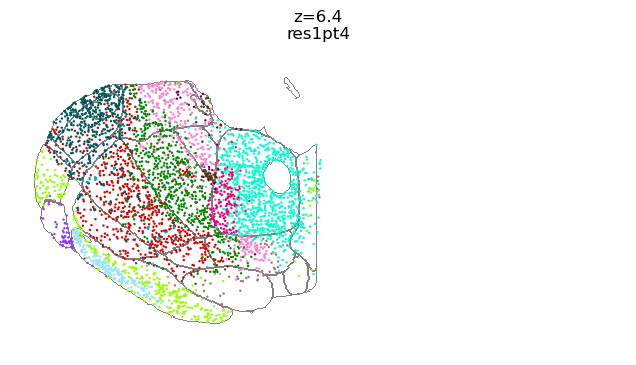

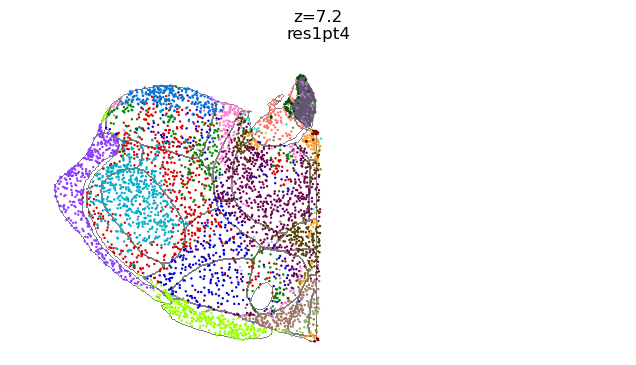

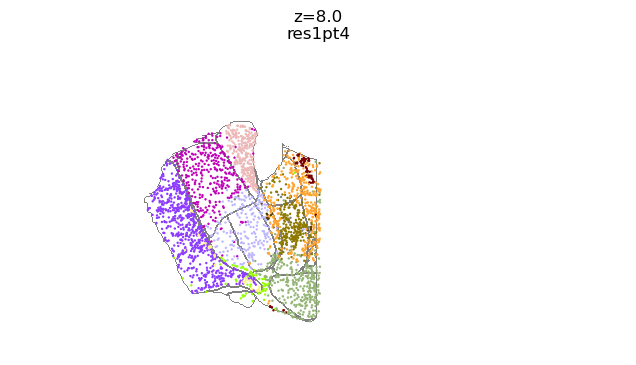

In [13]:
kwargs = dict(
    bg_cells=None,
    section_col=section_col,
    x_col = 'x_'+coords,
    y_col = 'y_'+coords,
    s=3, 
    shape_palette='dark_outline',
    boundary_img=ccf_boundaries
)
figs = cplots.plot_ccf_overlay(obs_spagcn, ccf_images, 
                               point_hue=predicted_col, 
                               sections=sections_GRC,
                               # point_palette=abc_palettes['subclass'],
                               legend=None,#'cells', 
                               **kwargs)

In [14]:
kwargs = dict(
    bg_cells=None,
    section_col=section_col,
    x_col = 'x_'+coords,
    y_col = 'y_'+coords,
    s=15, 
    shape_palette='dark_outline',
    boundary_img=ccf_boundaries
)

resolution = 1.4
res_str = str(resolution)
predicted_col = f'res{res_str[0]}pt{res_str[-1]}'
predicted_refined_col = f'res{res_str[0]}pt{res_str[-1]}_refined'

fig, point_palette = plot_ccf_overlay_montage(obs_spagcn, ccf_images, 
                               point_hue=predicted_col, 
                               sections=sections_GRC,
                               # point_palette=abc_palettes['subclass'],
                               legend=None, n_rows=1, set_lims='left_hemi',
                               # custom_xy_lims=[2.5, 6, 7.5, 4],
                               **kwargs)

fig.savefig(f'../results/spaGCN_domains_ccf_overlay_3sections_res{res_str}.pdf', 
            transparent=True, bbox_inches='tight')

AttributeError: module 'thalamus_merfish_analysis.ccf_plots' has no attribute 'get_thalamus_substructure_names'

{'6': (0.8392156862745098, 0.0, 0.0), '2': (0.5490196078431373, 0.23137254901960785, 1.0), '1': (0.00392156862745098, 0.5294117647058824, 0.0), '4': (0.0, 0.6745098039215687, 0.7764705882352941), '0': (0.592156862745098, 1.0, 0.0), '5': (1.0, 0.49411764705882355, 0.8196078431372549), '8': (0.4196078431372549, 0.0, 0.30980392156862746), '3': (1.0, 0.6470588235294118, 0.1843137254901961), '7': (0.3411764705882353, 0.23137254901960785, 0.0), '19': (0.0, 0.33725490196078434, 0.34901960784313724), '15': (0.0, 0.0, 0.8666666666666667), '18': (0.0, 0.9921568627450981, 0.8117647058823529), '11': (0.6313725490196078, 0.4588235294117647, 0.4117647058823529), '14': (0.7372549019607844, 0.7137254901960784, 1.0), '13': (0.5843137254901961, 0.7098039215686275, 0.4666666666666667), '9': (0.7490196078431373, 0.011764705882352941, 0.7215686274509804), '16': (0.39215686274509803, 0.32941176470588235, 0.4549019607843137), '27': (0.4745098039215686, 0.0, 0.0), '23': (0.027450980392156862, 0.45490196078431

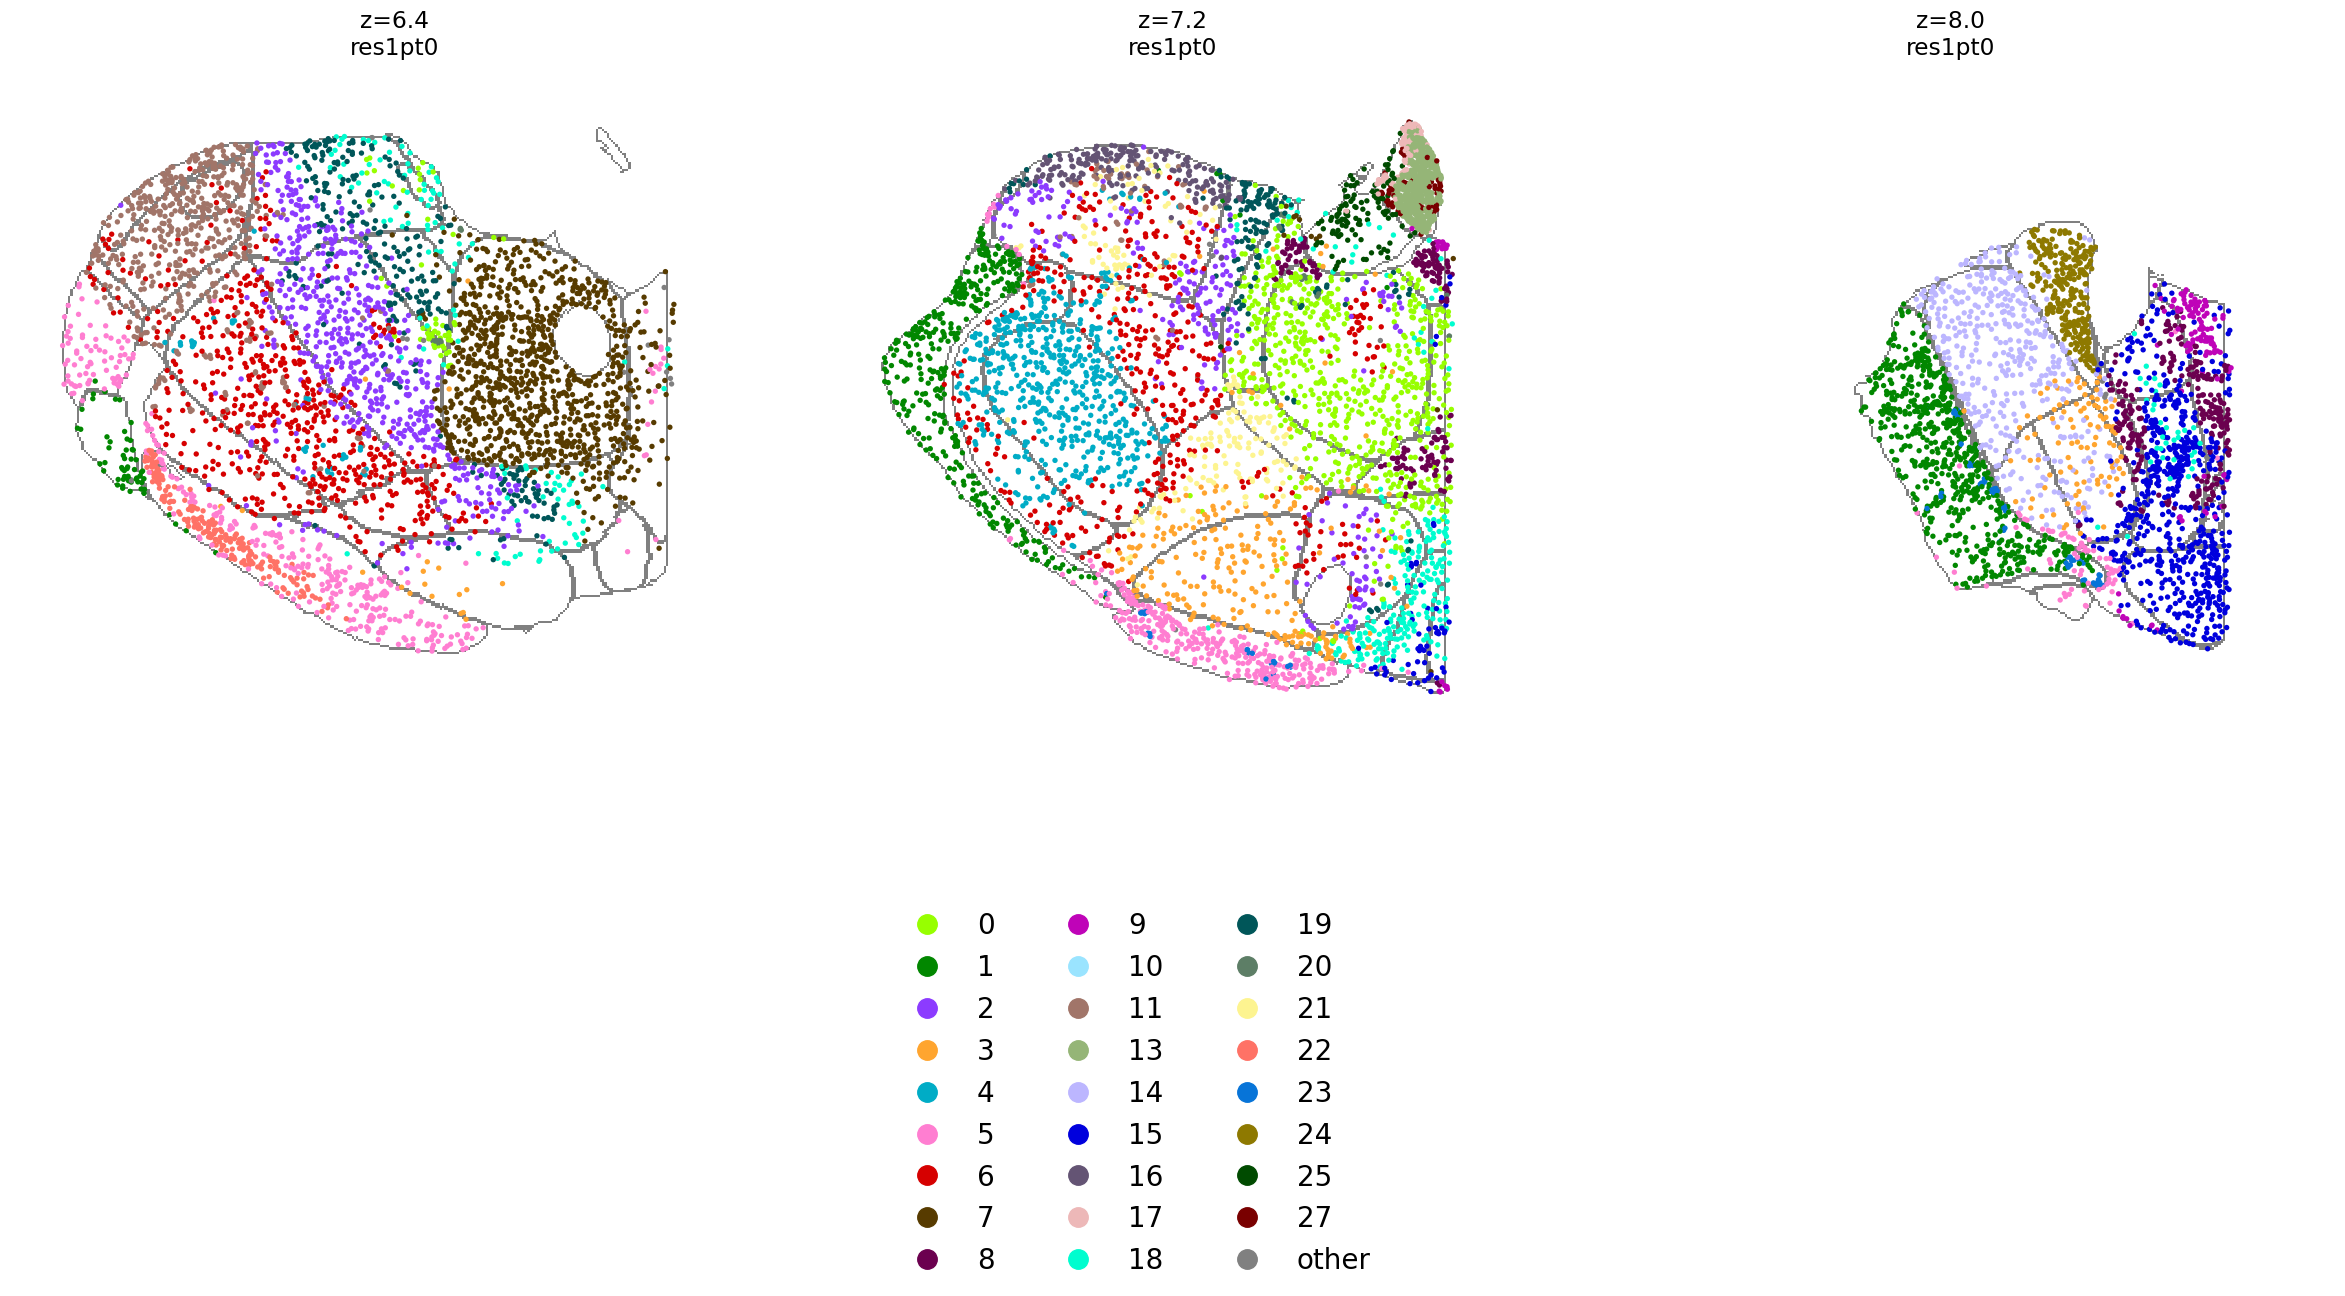

In [ ]:
# kwargs = dict(
#     bg_cells=None,
#     section_col=section_col,
#     x_col = 'x_'+coords,
#     y_col = 'y_'+coords,
#     s=15, 
#     shape_palette='dark_outline',
#     boundary_img=ccf_boundaries
# )

# resolution = 1.0
# res_str = str(resolution)
# predicted_col = f'res{res_str[0]}pt{res_str[-1]}'
# predicted_refined_col = f'res{res_str[0]}pt{res_str[-1]}_refined'

# fig, point_palette = plot_ccf_overlay_montage(obs_spagcn, ccf_images, 
#                                point_hue=predicted_col, 
#                                sections=sections_GRC,
#                                # point_palette=abc_palettes['subclass'],
#                                legend=None, n_rows=1, set_lims='left_hemi',
#                                # custom_xy_lims=[2.5, 6, 7.5, 4],
#                                **kwargs)

# fig.savefig(f'../results/spaGCN_domains_ccf_overlay_3sections.pdf', 
#             transparent=True, bbox_inches='tight')

In [ ]:
# fig = plot_domains_overlay(obs_spagcn, predicted_col, 
#                            ccf_images, ccf_boundaries,
#                            obsm_key=None, sections=sections_GRC, 
#                            n_rows=1, s=10, plot_title=None)

In [ ]:
from importlib import reload
reload(cplots)

<module 'thalamus_merfish_analysis.ccf_plots' from '/root/capsule/code/thalamus_merfish_analysis/ccf_plots.py'>

# Distance Metrics

## CCF overlap

In [ ]:
regions_subset = np.array([
    'AD',
    'AV',
    'LD',
    'LGd',
    # VP combine?
    'VPM',
    'VPL',
    'AM',
    'VPMpc',
    'MD',
    'LP',
    'PO',
    'IAD',
    'VAL',
    'VM',
    'RE',
    'CL',
    'PF',
    'CM',
    'PCN',
    'SPA',
    'IMD',
    'PVT',
    # additional
    'MH',
    'LH',
    'RT',
    # 'ZI'
])

In [ ]:
regions_final = [
    "AD", "AV", "AM", "IAD", "LD", "VPM", "VPL", "LGd",
    "MD", "CL", "CM", "IMD", "PO", "LP", "VAL", "VM", 
    "RE", "PF", "VPMpc", "PCN", "SPA", "PVT", "MH", "LH", "RT", 
]

In [ ]:
ax = fig.gca()

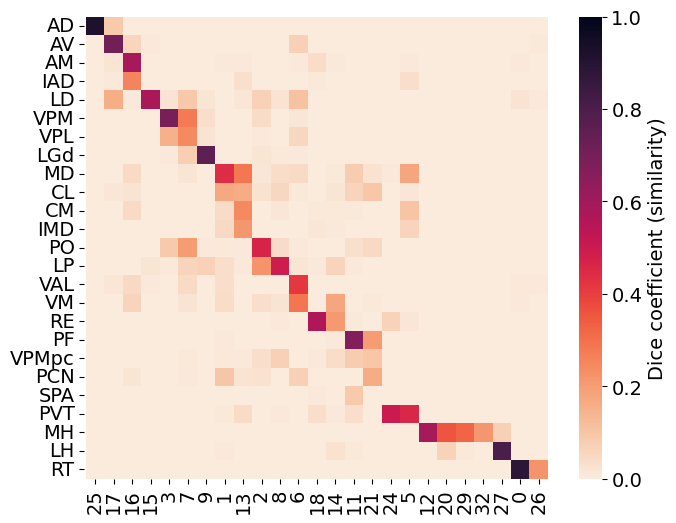

In [ ]:
# ccf region order here is fairly arbitrary 
dist, y_names, x_names = dm.cluster_distances_from_labels(
                            obs_spagcn, y_col=ccf_label, x_col=predicted_col, 
                            y_names=regions_final, 
                            x_names=sorted(obs_spagcn[predicted_col].unique()))

y_order, x_order = dm.order_distances_x_to_y(dist, reorder_y=True)

fig = dm.plot_ordered_similarity_heatmap(dist, 
                                         y_order=y_order, x_order=x_order, 
                                         y_names=y_names, x_names=x_names)

fig.set_size_inches(7.5,6)

fig.savefig(f'../results/similarity_heatmap_nuclei_vs_spaGCN_domains_reorderedY.pdf', 
            transparent=True, bbox_inches='tight')

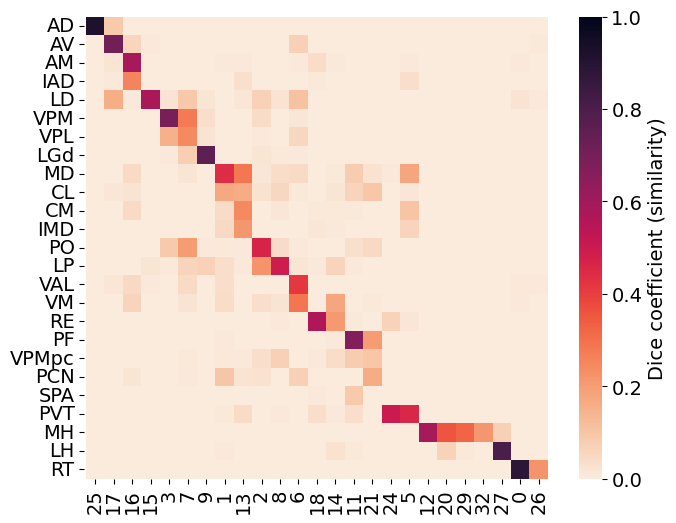

In [ ]:
dist, y_names, x_names = dm.cluster_distances_from_labels(
                            obs_spagcn, y_col=ccf_label, x_col=predicted_col, 
                            y_names=regions_final, 
                            x_names=sorted(obs_spagcn[predicted_col].unique()))

y_order, x_order = dm.order_distances_x_to_y(dist, reorder_y=False)

fig = dm.plot_ordered_similarity_heatmap(dist, 
                                         y_order=y_order, x_order=x_order, 
                                         y_names=y_names, x_names=x_names)

# fig.gca().axis('equal')
fig.set_size_inches(7.5,6)

fig.savefig(f'../results/similarity_heatmap_nuclei_vs_spaGCN_domains_notReorderedY.pdf', 
            transparent=True, bbox_inches='tight')

## Taxonomy overlap

### subclass

In [ ]:
# sorted(obs_spagcn['subclass'].cat.categories.to_list())

In [ ]:
subclasses_subset = ['093 RT-ZI Gnb3 Gaba',
                     '101 ZI Pax6 Gaba',
                     '103 PVHd-DMH Lhx6 Gaba',
                     '109 LGv-ZI Otx2 Gaba',
                     '145 MH Tac2 Glut',
                     '146 LH Pou4f1 Sox1 Glut',
                     '147 AD Serpinb7 Glut',
                     '148 AV Col27a1 Glut',
                     '149 PVT-PT Ntrk1 Glut',
                     '150 CM-IAD-CL-PCN Sema5b Glut',
                     '151 TH Prkcd Grin2c Glut',
                     '152 RE-Xi Nox4 Glut',
                     '154 PF Fzd5 Glut',
                     # '168 SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut', # cut off by midline xcoord bug
                     # '197 SNr Six3 Gaba',
                     # '202 PRT Tcf7l2 Gaba',
                     # '203 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba' # also cut off by midline xcoord bug??
                     ]

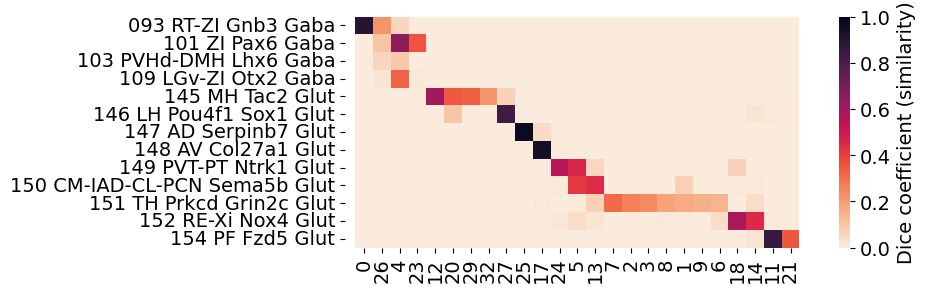

In [ ]:
taxonomy_level = 'subclass'
dist, y_names, x_names = dm.cluster_distances_from_labels(
                            obs_spagcn, y_col=taxonomy_level, x_col=predicted_col, 
                            y_names=subclasses_subset, 
                            x_names=sorted(obs_spagcn[predicted_col].unique()))

y_order, x_order = dm.order_distances_x_to_y(dist, reorder_y=False, 
                                             min_similarity_x=0.1)

fig = dm.plot_ordered_similarity_heatmap(dist, 
                                         y_order=y_order, x_order=x_order, 
                                         y_names=y_names, x_names=x_names)
fig.gca().axis('equal')
fig.set_size_inches(7.5,3)

fig.savefig(f'../results/similarity_heatmap_subclass_vs_spaGCN_domains_reorderedY.pdf', 
            transparent=True, bbox_inches='tight')

### supertype

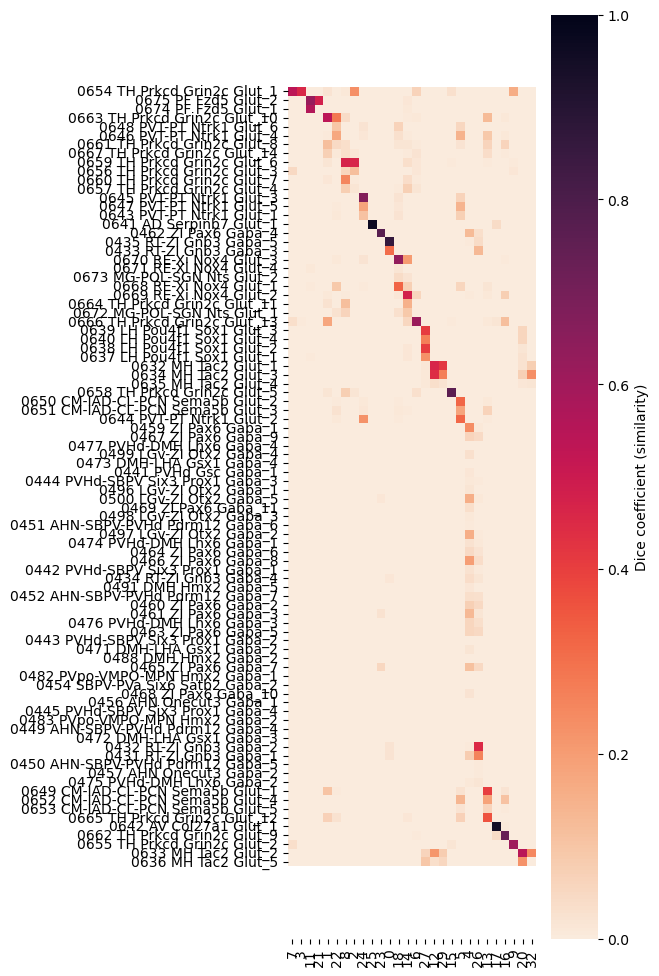

In [ ]:
taxonomy_level = 'supertype'
dist, y_names, x_names = dm.cluster_distances_from_labels(
                            obs_spagcn, y_col=taxonomy_level, x_col=predicted_col, 
                            y_names=None, 
                            x_names=sorted(obs_spagcn[predicted_col].unique()))

y_order, x_order = dm.order_distances_x_to_y(dist, reorder_y=True)

fig = dm.plot_ordered_similarity_heatmap(dist, 
                                         y_order=y_order, x_order=x_order, 
                                         y_names=y_names, x_names=x_names)
fig.gca().axis('equal')
fig.set_size_inches(4, 12)

### clusters

In [ ]:
cluster_list = sorted(obs_spagcn['cluster'].cat.categories.to_list())
clusters_grin2c = [cl for cl in cluster_list if 'Grin2c' in cl]
# clusters_grin2c

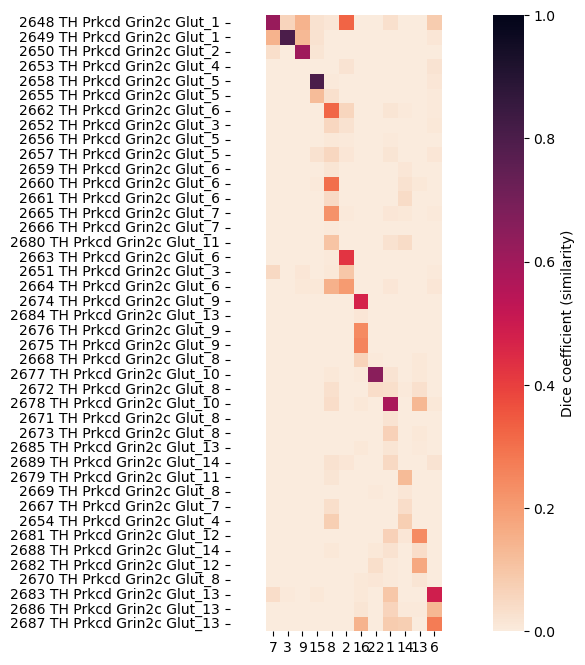

In [ ]:
taxonomy_level = 'cluster'
dist, y_names, x_names = dm.cluster_distances_from_labels(
                            obs_spagcn, y_col=taxonomy_level, x_col=predicted_col, 
                            y_names=clusters_grin2c, 
                            x_names=sorted(obs_spagcn[predicted_col].unique()))

y_order, x_order = dm.order_distances_x_to_y(dist, reorder_y=True)

fig = dm.plot_ordered_similarity_heatmap(dist, 
                                         y_order=y_order, x_order=x_order, 
                                         y_names=y_names, x_names=x_names)
fig.gca().axis('equal')
fig.set_size_inches(4, 8)